<font size='20'>Tornado Impact - Data Analysis</font>

**Authors:**

* Andrea Johnson
* Damir Zunic
* Lindsey Downs

# Introduction

We are all interested in weather data, but more specifically interested in the tornado events that occur both locally and nationally.  Our project is to look at the geographic distribution of tornado events in the United States, with focus on the various “measurements of impact”, from the loss of life to the financial ramifications, and explore how the geographic distribution and measurements of impact for Indiana measure up against the national results.


## Data Source

In this research we are using publicly available [NCEI (Storm Events Database](https://www.ncdc.noaa.gov/stormevents/ftp.jsp). It contains various type of storms from January 1950 to December 2019, entered by NOAA's National Weather Service (NWS). Data are available in comma-separated value (CSV) files, three files per year: "details", "locations" and "fatalities".

In our reserach we will be using only "details" files from 1996 to 2019.

**Description of Features:**

Those files have been read, cleanead and transformed to one file that contents only tornado events and features relevant to this project. The cleanup process is described in the Jupyter notebook ["Tornado Impact - Data Exploration and Cleanup.](https://butler.bootcampcontent.com/zunicd/project_one/blob/master/Tornado%20Impact%20-%20Data%20Exploration%20and%20Cleanup.ipynb)

The number of fetaures have been reduced to the following 11 features:

|Feature Name|Description|
|---|---|
|EVENT_ID|ID assigned by NWS to note a single, small part of a storm episode|
|STATE|The state name where the event occurred|
|YEAR|Four digit year for the event in this record|
|MONTH_NAME|Name of the month for the event in this record|
|BEGIN_DATE_TIME|Beginning  of the eventMM/DD/YYYY 24 hour time AM/PM|
|TOR_F_SCALE|The strength of the tornado on Enhanced Fujita Scale|
|BEGIN_LAT|The latitude where the event occurred|
|BEGIN_LON|The longitude where the event occurred|
|INJURIES|The number of injuries, direct and indirect combined|
|DEATHS|The number of deaths, direct and indirect combined|
|DAMAGE|The estimated amount of damage to property and crops combined|


The new file has 33006 observations and as it was mentioned above, 11 features. There are 38 observations with NaN values. All of them are for both coordinates and majoriy are for Oklahoma in 1996. 


## Challenges

We have faced several challenges during this project.

* Values for "damages" features in our dataset were string values (1K, 1M, …). To be able to calculate with them we had to convert them to floats. 


* Then we faced another problem, with one “dirty” record. That record did not have any number, just letter “K” and it crashed our code. We had to manually update this record in the .csv file to “0K”.


* State names in the "us-states" GeoJSON geometry are in title case and our dataset has capitalized state names. We had to convert names in the dataframe to match GeoJSON names.


* "citipy” is providing only city names, no states. In case when a city is  having the same name as other cities or the same name as counties or countries, Geocoding API might return incorrect coordinates. One example is city Lebanon, IN and the country Lebanon. It would be nice to get (city, state) pair from “citipy".



## Findings

* We have found out that 2011 was the worst year in recent history for all of the measurements of impact.  Each measurement of impact -- Deaths, Injuries, and Damage -- are correlated. Not only the total tornado frequency was the highest in history, but the frequency of F/EF4 abd F/EF5 tornadoes was 4 times higher than other years.


* The higher frequency (or count) of tornado events does not necessarily mean greater impact. As we will show, higher scale tornadoes (F/EF4 and F/EF5) have more impact to tornado related deaths, injuries and damages than just tornado frequency. 


* Indiana's rankings:
<pre>Annual Average of Tornadoes: 	  		    <b>19th</b> 
Annual Average of Tornadoes per 10K sq mi: 	<b>11th</b>
Total Number of Tornado Fatalities:            <b>11th</b></pre>


* **Seasonality of tornadoes** - We have proved the seasonal nature of tornadoes with May at the top, closely followed by April and June as months when tornadoes are most common.


* The most common disaster supported by FEMA public assistance is Hurricanes.  Typically, property insurance claims cover the tornado damages.  FEMA data and NWS data do not correlate.


## Motivation

Living in Indiana, one of the states that are sometimes included in Tornado Alley, and going frequently through warnings and safety procedures, it is normal that we are asking a lot of questions about tornadoes. This project will try to answer some of the questions.

## Library Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
import gmaps.geojson_geometries
import json
import requests
from citipy import citipy
import cpi

from matplotlib import cm
from matplotlib.cm import inferno
import matplotlib.ticker as tkr
from matplotlib.colors import to_hex

from config import gkey
gmaps.configure(api_key=gkey)

## Create Dataframe

Using the csv file created in the notebook *Tornado Impact - Data Exploration and Cleanup.ipynb*

In [3]:
# Read the file and create dataframe
df_tor = pd.read_csv('./Resources/TornadoEvents.csv')
df_tor.head()

,EVENT_ID,STATE,YEAR,MONTH_NAME,BEGIN_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,INJURIES,DEATHS,DAMAGE
0,5539021,MISSOURI,1996,January,18-JAN-96 08:05:00,F1,36.18,-89.87,0,0,50000.0
1,5535520,ARKANSAS,1996,January,18-JAN-96 07:30:00,F1,34.55,-90.97,3,0,30000.0
2,5574627,LOUISIANA,1996,January,26-JAN-96 09:35:00,F1,30.57,-92.32,3,0,15000.0
3,5558382,INDIANA,1996,January,18-JAN-96 14:30:00,F0,40.50,-86.97,0,0,0.0
4,5535845,TEXAS,1996,January,17-JAN-96 21:55:00,F2,33.72,-96.15,5,0,150000.0


In [4]:
df_tor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33006 entries, 0 to 33005
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EVENT_ID         33006 non-null  int64  
 1   STATE            33006 non-null  object 
 2   YEAR             33006 non-null  int64  
 3   MONTH_NAME       33006 non-null  object 
 4   BEGIN_DATE_TIME  33006 non-null  object 
 5   TOR_F_SCALE      33006 non-null  object 
 6   BEGIN_LAT        32968 non-null  float64
 7   BEGIN_LON        32968 non-null  float64
 8   INJURIES         33006 non-null  int64  
 9   DEATHS           33006 non-null  int64  
 10  DAMAGE           33006 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 2.8+ MB


# Choropleth maps with GeoJSON

To draw [choropleth](https://en.wikipedia.org/wiki/Choropleth_map) maps it is useful to add GeoJSON layer to maps. 

**Convert state names in dataframe to titlecase to match the case found in GeoJSON.**

State names in GeoJSON document are listed as title case. We need to convert names in our dataframe.

In [5]:
# Copy dataframe
tor_geo = df_tor.copy()

# Convert state names to titlecase to match names in GeoJSON
tor_geo['STATE'] = tor_geo['STATE'].str.title()

# Virgin Islands not listed in GeoJSON for US states so droping here
tor_geo = tor_geo.loc[tor_geo['STATE'] != 'Virgin Islands']

# Convert "Of" in "District Of Columbia" to lower case to match names in GeoJSON
tor_geo.replace({'STATE':'District Of Columbia'}, 'District of Columbia', inplace=True)

# Display first 5 rows
tor_geo.head()

,EVENT_ID,STATE,YEAR,MONTH_NAME,BEGIN_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,INJURIES,DEATHS,DAMAGE
0,5539021,Missouri,1996,January,18-JAN-96 08:05:00,F1,36.18,-89.87,0,0,50000.0
1,5535520,Arkansas,1996,January,18-JAN-96 07:30:00,F1,34.55,-90.97,3,0,30000.0
2,5574627,Louisiana,1996,January,26-JAN-96 09:35:00,F1,30.57,-92.32,3,0,15000.0
3,5558382,Indiana,1996,January,18-JAN-96 14:30:00,F0,40.50,-86.97,0,0,0.0
4,5535845,Texas,1996,January,17-JAN-96 21:55:00,F2,33.72,-96.15,5,0,150000.0



We will load **_us-states_** geometry from GeoJSON geometries bundled with **gmaps**.

In [6]:
# Load us-states geometry and list states in it
us_states_geojson = gmaps.geojson_geometries.load_geometry('us-states')
states = []
for feature in us_states_geojson['features']:
    states.append(feature['properties']['NAME'])

# Display first 5 states
sorted(states)[0:5]

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California']

**Function *prep_colors* is preparing an array of colors and passing it to GeoJSON layer.**

In [7]:
def prep_colors(s_val, cmap):
    """
    s_val - series with values for each state to map to color
    cmap - Matplotlib color map
    """
    # Define dictionary that maps country to value to plot
    state2toval  = s_val.to_dict()
    # Display first 5 key-value pairs in dictionary
    #list(state2toval.items())[0:5]

    # Use state2val dictionary to map each state to a color. 
    # Scale dictionary values to lie between 0 and 1
    min_tor = min(state2toval.values())
    max_tor = max(state2toval.values())
    tor_range = max_tor - min_tor

    def calculate_color(tor):
        """
        Convert tornado to a color
        """
        # make tornado count between 0 and 1
        norm_tor = (tor - min_tor) / tor_range

        # invert so that high tornado counts gives dark color
        inverse_tor = 1.0 - norm_tor

        # transform values to a matplotlib color
        mpl_color = cmap(inverse_tor)

        # transform from a matplotlib color to a valid CSS color
        gmaps_color = to_hex(mpl_color, keep_alpha=False)

        return gmaps_color

    # Build an array of colors, one for each state, and pass it to GeoJSON layer.
    us_states_geojson = gmaps.geojson_geometries.load_geometry('us-states')
    colors = []
    for feature in us_states_geojson['features']:
        state_name = feature['properties']['NAME']
        try:
            tor = state2toval[state_name]
            color = calculate_color(tor)
        except KeyError:
            # no count for that state: return default color
            print(state_name)
            color = (0, 0, 0, 0.3)
        colors.append(color)
    return colors


## Annual Average of Tornadoes per State (1996 - 2019)

In [8]:
# Create series with tornado count for each state (1996 -2019)
s_tor = tor_geo.STATE.value_counts().sort_index()

s_tor.head()

Alabama       1581
Alaska           3
Arizona        105
Arkansas      1240
California     232
Name: STATE, dtype: int64

In [9]:
# Count average number of tornadoes per state in period 1996 - 2019
nyears = tor_geo.YEAR.nunique()
s_tor_avg = round((s_tor / nyears), 2)

s_tor_avg.head()

Alabama       65.88
Alaska         0.12
Arizona        4.38
Arkansas      51.67
California     9.67
Name: STATE, dtype: float64

In [10]:
# Calculate top 10 states in reverse order
s_tor_avg10 = s_tor_avg.sort_values(ascending=False)[:10][::-1]   # Indiana is 19th
s_tor_avg10

Nebraska        53.33
Florida         55.54
Iowa            57.42
Missouri        57.54
Mississippi     63.17
Illinois        63.62
Alabama         65.88
Oklahoma        76.08
Kansas          96.29
Texas          139.54
Name: STATE, dtype: float64

**Plot top 10 states with average number of tornadoes.**

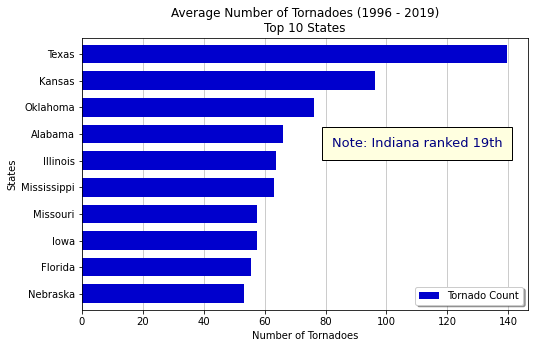

In [11]:
# Generate bar plot
fig, ax = plt.subplots(figsize=(8, 5))
s_tor_avg10.plot(kind='barh',
                 color='mediumblue',
                 alpha=1,
                 rot=0,
                 legend=True,
                 label='Tornado Count',
                 width=0.7,
                 ax=ax)                                       

# Set textual properties
plt.title('Average Number of Tornadoes (1996 - 2019)\nTop 10 States')
plt.xlabel('Number of Tornadoes')
plt.ylabel('States')
plt.text(82, 5.5,"Note: Indiana ranked 19th", 
         color='navy', fontsize=13, 
         bbox={'facecolor':'lightyellow', 'alpha':1.0, 'pad':10})

plt.legend(fancybox=True, shadow=True)

# set grid for y axis
ax.set_axisbelow(True)
ax.grid(axis='x', alpha=0.8)

#plt.savefig('./Images/Tornadoes Avg Number - Top 10')
plt.show()

Texas is the state with most tornadoes in the period 1996 - 2019, followed by Kansas, Oklahoma and Alabama. Indiana was ranked 19th.

**Prepare colors and plot the map**

Runing function **prep_colors** with tornado average series and colormap **inferno**.

In [12]:
# Prepare colors to pass to GeoJSON leyer
colors = prep_colors(s_tor_avg, inferno)

In [13]:
# Plot map
# Load us-states geometry
us_states_geojson = gmaps.geojson_geometries.load_geometry('us-states')

# Build base map
fig = gmaps.figure(center=(39, -98), zoom_level=4)

# Build geojson layer
tornado_layer = gmaps.geojson_layer(us_states_geojson,
                                    fill_color=colors,
                                    stroke_color=colors,
                                    fill_opacity=0.6)

fig.add_layer(tornado_layer)

fig

Figure(layout=FigureLayout(height='420px'))

On the above map we can clearly see so called **"Tornado Alley"**, the area of the United State where tornadoes are most frequent.

## Annual Average of Tornadoes per 10K sq mi per State (1996 - 2019)

Let's see the map of tornadoes by states when we take in consideration the size of each state.

**Extract area for each state from GeoJSON geometry**

We will extartct the size of each state in square miles from GeoJSON document.

In [14]:
# Define empty dataframe
states_area = pd.DataFrame()
states_area['STATE'] = ""
states_area['AREA'] = ""

# Populate dataframe from GeoJSON
ind = 0
for feature in us_states_geojson['features']:
    states_area.loc[ind, 'STATE'] = feature['properties']['NAME']
    states_area.loc[ind, 'AREA']= feature['properties']['CENSUSAREA']
    ind += 1

# Convert object to float for AREA and sort per state   
states_area.AREA = states_area.AREA.astype(float)
states_area = states_area.sort_values('STATE')

states_area.head()

,STATE,AREA
25,Alabama,50645.326
26,Alaska,570640.950
0,Arizona,113594.084
1,Arkansas,52035.477
2,California,155779.220


In [15]:
# Create series with area as values
states_area.set_index('STATE', inplace=True)
s_area = states_area.AREA
s_area.head()

STATE
Alabama        50645.326
Alaska        570640.950
Arizona       113594.084
Arkansas       52035.477
California    155779.220
Name: AREA, dtype: float64

In [16]:
# Rename series name
s_tor_avg.name='AVG_COUNT'
s_tor_avg.head()

Alabama       65.88
Alaska         0.12
Arizona        4.38
Arkansas      51.67
California     9.67
Name: AVG_COUNT, dtype: float64

In [17]:
# Join two series, remove name for index axis
tor_area = pd.concat([s_tor_avg, s_area], axis=1)
tor_area.index.name=None
tor_area.head()

,AVG_COUNT,AREA
Alabama,65.88,50645.326
Alaska,0.12,570640.950
Arizona,4.38,113594.084
Arkansas,51.67,52035.477
California,9.67,155779.220


In [18]:
# Add column with average tornado count per 10K sq mi
tor_area['Tornadoes per 10K sq mi'] = round((10000 * tor_area.AVG_COUNT / tor_area.AREA), 0)

tor_area.head()

,AVG_COUNT,AREA,Tornadoes per 10K sq mi
Alabama,65.88,50645.326,13.0
Alaska,0.12,570640.950,0.0
Arizona,4.38,113594.084,0.0
Arkansas,51.67,52035.477,10.0
California,9.67,155779.220,1.0


In [19]:
# Create series for average tornado count per 10K sq mi
s_tor_area = tor_area['Tornadoes per 10K sq mi']
s_tor_area.head()

Alabama       13.0
Alaska         0.0
Arizona        0.0
Arkansas      10.0
California     1.0
Name: Tornadoes per 10K sq mi, dtype: float64

In [20]:
# Calculate top 10 states in reverse order
s_tor_area10 = s_tor_area.sort_values(ascending=False)[:10][::-1]   # Indiana is 11th
s_tor_area10

Iowa                    10.0
Florida                 10.0
Arkansas                10.0
Louisiana               11.0
Illinois                11.0
Oklahoma                11.0
Kansas                  12.0
Mississippi             13.0
Alabama                 13.0
District of Columbia    20.0
Name: Tornadoes per 10K sq mi, dtype: float64

**Plot top 10 states with average number of tornadoes per 10K square miles.**

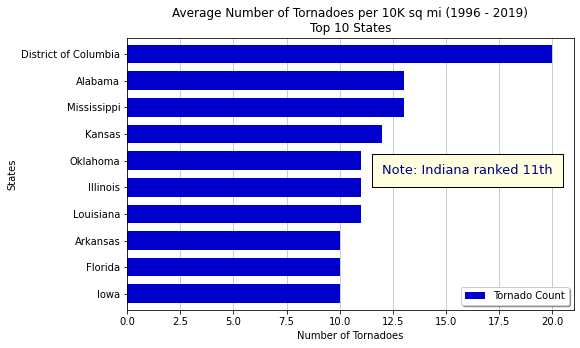

In [21]:
# Generate bar plot
fig, ax = plt.subplots(figsize=(8, 5))
s_tor_area10.plot(kind='barh',
                 color='mediumblue',
                 alpha=1,
                 rot=0,
                 legend=True,
                 label='Tornado Count',
                 width=0.7,
                 ax=ax)                                       

# Set textual properties
plt.title('Average Number of Tornadoes per 10K sq mi (1996 - 2019)\nTop 10 States')
plt.xlabel('Number of Tornadoes')
plt.ylabel('States')
plt.text(12, 4.5,"Note: Indiana ranked 11th", 
         color='navy', fontsize=13, 
         bbox={'facecolor':'lightyellow', 'alpha':1.0, 'pad':10})


plt.legend(fancybox=True, shadow=True)

# set grid for y axis
ax.set_axisbelow(True)
ax.grid(axis='x', alpha=0.8)

#plt.savefig('./Images/Tornadoes Avg Number per 10K sq mi - Top 10')
plt.show()

As expected there are some changes comparing to the previous plot. Two changes are very obvious. First, District of Columbia, because of its small size, had most tornadoes per 10K square miles (20). Second, opposite to DC, Texas as a very big state is ranked 25th, with 5 tornadoes per 10K square miles. 

**Prepare colors and plot the map**

Runing function **prep_colors** with tornado average per area series and colormap **inferno**.

In [22]:
# Prepare colors to pass to GeoJSON leyer
colors = prep_colors(s_tor_area, inferno)

In [23]:
us_states_geojson = gmaps.geojson_geometries.load_geometry('us-states')

fig = gmaps.figure(center=(39, -98), zoom_level=4)

tornado_layer = gmaps.geojson_layer(us_states_geojson,
                                    fill_color=colors,
                                    stroke_color=colors,
                                    fill_opacity=0.6)

fig.add_layer(tornado_layer)

fig

Figure(layout=FigureLayout(height='420px'))

**"Tornado Alley"** is still very noticeable with Texas plotted in brighter color.

## Total Tornado Fatalities per State (1996 - 2019)

Let's see how tornado fatalities are distibuted over the states.

In [24]:
tor_geo.head()

,EVENT_ID,STATE,YEAR,MONTH_NAME,BEGIN_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,INJURIES,DEATHS,DAMAGE
0,5539021,Missouri,1996,January,18-JAN-96 08:05:00,F1,36.18,-89.87,0,0,50000.0
1,5535520,Arkansas,1996,January,18-JAN-96 07:30:00,F1,34.55,-90.97,3,0,30000.0
2,5574627,Louisiana,1996,January,26-JAN-96 09:35:00,F1,30.57,-92.32,3,0,15000.0
3,5558382,Indiana,1996,January,18-JAN-96 14:30:00,F0,40.50,-86.97,0,0,0.0
4,5535845,Texas,1996,January,17-JAN-96 21:55:00,F2,33.72,-96.15,5,0,150000.0


In [25]:
# Group by state and sum deaths for each state
s_deaths = tor_geo.groupby('STATE').DEATHS.sum()
s_deaths.head()

STATE
Alabama       380
Alaska          0
Arizona         0
Arkansas      120
California      0
Name: DEATHS, dtype: int64

In [26]:
# Calculate top 10 states in reverse order
s_deaths10 = s_deaths.sort_values(ascending=False)[:10][::-1]   # Indiana is 11th
s_deaths10

STATE
North Carolina     48
Florida            80
Texas              90
Georgia           102
Mississippi       103
Arkansas          120
Oklahoma          126
Tennessee         166
Missouri          248
Alabama           380
Name: DEATHS, dtype: int64

**Plot top 10 states with total number of fatalities.**

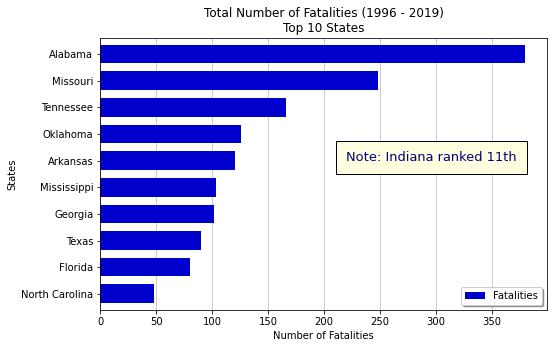

In [27]:
# Generate bar plot
fig, ax = plt.subplots(figsize=(8, 5))
s_deaths10.plot(kind='barh',
                 color='mediumblue',
                 alpha=1,
                 rot=0,
                 legend=True,
                 label='Fatalities',
                 width=0.7,
                 ax=ax)                                       

# Set textual properties
plt.title('Total Number of Fatalities (1996 - 2019)\nTop 10 States')
plt.xlabel('Number of Fatalities')
plt.ylabel('States')
plt.text(220, 5,"Note: Indiana ranked 11th", 
         color='navy', fontsize=13, 
         bbox={'facecolor':'lightyellow', 'alpha':1.0, 'pad':10})


plt.legend(fancybox=True, shadow=True)

# set grid for y axis
ax.set_axisbelow(True)
ax.grid(axis='x', alpha=0.8)

#plt.savefig('./Images/Total Number of Fatalities - Top 10')
plt.show()

Alabama had most fatalities, followed by Missouri and Tennessee. Indiana is ranked 11th.

**Prepare colors and plot the map**

Runing function **prep_colors** with tornado deaths series and colormap **inferno**.

In [28]:
# Prepare colors to pass to GeoJSON leyer
colors = prep_colors(s_deaths, inferno)

In [29]:
us_states_geojson = gmaps.geojson_geometries.load_geometry('us-states')

fig = gmaps.figure(center=(39, -98), zoom_level=4)

tornado_layer = gmaps.geojson_layer(us_states_geojson,
                                    fill_color=colors,
                                    stroke_color=colors,
                                    fill_opacity=0.6)

fig.add_layer(tornado_layer)

fig

Figure(layout=FigureLayout(height='420px'))

From the map we can conclude that south states of 'Tornado Alley" have most fatalities, with exception of Missouri.

## Tornado Heatmap for Total Count (1996 - 2019)

In [30]:
# Copy dataframe
tor_heat = df_tor.copy()

# Check for missing values
len(tor_heat[tor_heat.isna().any(axis=1)])

38

In [31]:
# Drop rows with missing coordinates
tor_heat.dropna(inplace=True)
tor_heat.shape

(32968, 11)

**Use citipy to determine cities closest to tornadoes' latitude and longitude**

In [32]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create list of tuples with tornadoes coordinates
for x in range(len(tor_heat)):
    lat_lngs.append((tor_heat.iloc[x, 6], tor_heat.iloc[x, 7]))

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    cities.append(city)

# Print the city count 
len(cities)

32968

In [33]:
# Create dataframe
tor_h = pd.DataFrame(cities, columns=['Cities'])

tor_h.head()

,Cities
0,kennett
1,west helena
2,eunice
3,west lafayette
4,bonham


In [34]:
# Calculate number of unique cities
tor_h.nunique()

Cities    2142
dtype: int64

In [35]:
# Define dataframe with counts of each city
tor_h = tor_h.Cities.value_counts().to_frame().reset_index()
tor_h = tor_h.rename(columns={'Cities': 'Count', 'index': 'Cities'})
tor_h['Cities'] = tor_h['Cities'].str.title()
tor_h.head()

,Cities,Count
0,Lamar,302
1,Garden City,291
2,Hays,269
3,Dodge City,267
4,Sterling,256


In [36]:
# Add columns for lat, lng, 
tor_h['Lat'] = ""
tor_h['Lng'] = ""

tor_h.head()

,Cities,Count,Lat,Lng
0,Lamar,302,,
1,Garden City,291,,
2,Hays,269,,
3,Dodge City,267,,
4,Sterling,256,,


In [37]:
tor_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Cities  2142 non-null   object
 1   Count   2142 non-null   int64 
 2   Lat     2142 non-null   object
 3   Lng     2142 non-null   object
dtypes: int64(1), object(3)
memory usage: 67.1+ KB


**Get the coordinates for the cities in the dataframe tor_h. They will be used for plotting heatmap.**

We will run the following cell only if needed. It retrieves coordintes for more than 2000 cities and it takes some time.

The ouput will be saved in the .csv file and read it afterwards.

Uncomment lines only if there is need to run it again.

In [38]:
# # create a params dict that will be updated with new city each iteration
# params = {'key': gkey}
# base_url = 'https://maps.googleapis.com/maps/api/geocode/json?'

# # Loop through tor_h and get latitude and longitude for each city
# for index, row in tor_h.iterrows():
    
#     city = row['Cities']
#     # print(f"Processing Record {index} | {city}")
#     # update address key value
#     params['address'] = f"{city}"
    
#     # make request
#     cities_rq = requests.get(base_url, params).json()
    
#     try:
#         tor_h.loc[index, 'Lat'] = cities_rq['results'][0]['geometry']['location']['lat']
#         tor_h.loc[index, 'Lng'] = cities_rq['results'][0]['geometry']['location']['lng']
#     except (KeyError, IndexError):
#         print(f'City {city} not found. Skipping...')
#         tor_h.drop(index, inplace=True)

#  # Visualize to confirm lat lng appear
# tor_h.head()      

To avoid frequent use of API for more than 2000 records, we will save the dataframe to the .csv file and read it in subseqent runs of the notebook.

In [39]:
# # Save dataframe to csv file
# tor_h.to_csv('./Outputs/Tornado_heatmap_cities.csv', index=False)

# Read .csv file to dataframe
tor_h = pd.read_csv('./Outputs/Tornado_heatmap_cities.csv')
tor_h.head()

,Cities,Count,Lat,Lng
0,Lamar,302,30.039905,-94.075575
1,Garden City,291,37.971690,-100.872662
2,Hays,269,38.879178,-99.326770
3,Dodge City,267,37.752798,-100.017079
4,Sterling,256,42.437416,-71.760629


In [40]:
tor_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Cities  2142 non-null   object 
 1   Count   2142 non-null   int64  
 2   Lat     2142 non-null   float64
 3   Lng     2142 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 67.1+ KB


In [41]:
# Convert object to float for Lat and Lng  
tor_h.Lat= tor_h.Lat.astype(float)
tor_h.Lng= tor_h.Lng.astype(float)
tor_h.dtypes

Cities     object
Count       int64
Lat       float64
Lng       float64
dtype: object

In [42]:
# Store latitude and longitude in locations
locations = tor_h[['Lat','Lng']]

# Use count as weights
counts = tor_h['Count']

In [43]:
# Plot Heatmap
fig = gmaps.figure(center=(39, -98), zoom_level=4)

# Create heat layer
tornado_heat_layer = gmaps.heatmap_layer(locations,
                                 weights=counts,
                                 dissipating=False,
                                 max_intensity=300,
                                 point_radius=1.7)
# Add layer
fig.add_layer(tornado_heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

Tornado heatmap nicely corresponds to the choropleth maps above.

# Additional insights from Tornado Data

## Seasonality of Tornadoes

**Average number of tornadoes for each month**

We are going to create a dataframe with months as indexes and average number of tornadoes per months as a column.

In [44]:
# Create series with average annual number of tornadoes, converted to dataframe and reset index
tor_months = round(df_tor.MONTH_NAME.value_counts() / nyears, 0).to_frame().reset_index()

# Rename both columns
tor_months = tor_months.rename(columns={'MONTH_NAME': 'Tornadoes', 'index': 'Months'})

# Convert column Months to category object, define custom order of categories
tor_months.Months = pd.Categorical(tor_months.Months, ['January', 'February', 'March', 'April', 'May',
                                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

# Sort dataframe per months and set Months as index for plotting
tor_months= tor_months.sort_values('Months').set_index('Months')

tor_months

,Tornadoes
Months,
January,47.0
February,48.0
March,95.0
April,221.0
May,304.0
June,215.0
July,115.0
August,82.0
September,76.0


**Total number of fatalities for each month**

We are going to create a dataframe with months as indexes and total number of fatalities per months as a column.

In [45]:
# Create series with total number of deaths, converted to dataframe and reset index
death_months = round(df_tor.groupby('MONTH_NAME').DEATHS.sum(), 0).to_frame().reset_index()

# Rename both columns
death_months = death_months.rename(columns={'MONTH_NAME': 'Months', 'DEATHS': 'Deaths'})

# Convert column Months to category object, define custom order of categories
death_months.Months = pd.Categorical(death_months.Months, ['January', 'February', 'March', 'April', 'May',
                                                  'June', 'July', 'August', 'September', 'October', 'November', 'December'])

# Sort dataframe per months and set Months as index for plotting
#death_months = death_months.sort_values('Months').set_index('Months')
death_months = death_months.set_index('Months').sort_index()

death_months

,Deaths
Months,
January,60
February,199
March,178
April,608
May,467
June,45
July,16
August,15
September,23


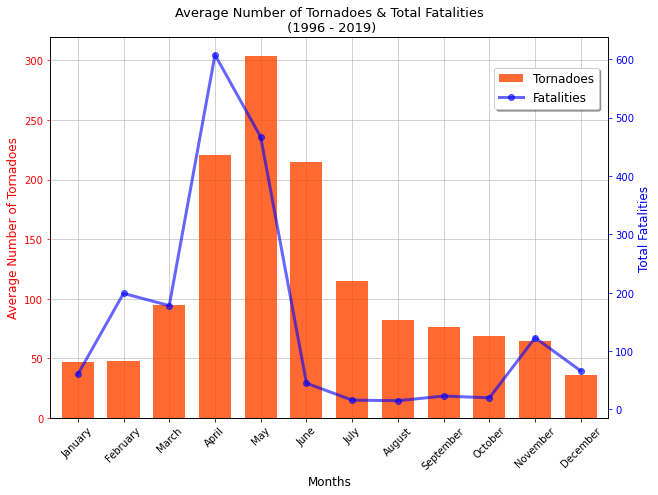

In [46]:
# Generate plot with 2 y-axes
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.set_title('Average Number of Tornadoes & Total Fatalities\n (1996 - 2019)', fontsize=13)


y1_label = 'Average Number of Tornadoes'
y2_label = 'Total Fatalities'

tor_months.plot(kind='bar',
                 color='orangered',
                 alpha=0.8,
                 rot=45,
                 legend=False,
                 width=0.7,
                 ax=ax)                                       

ax2 = ax.twinx()

death_months.plot(kind='line',
                color='blue',
                 alpha=0.6,
                 marker='o',
                 linewidth=3,
                 legend=False,
                 ax=ax2) 

fig.legend(labels=('Tornadoes', 'Fatalities'), 
           loc=1, 
           bbox_to_anchor=(0.84, 0.86),
           fancybox=True, 
           fontsize=12, 
           shadow=True)

# set grid
ax.set_axisbelow(True)
ax.grid(alpha=0.7)

ax.set_xlabel('Months', fontsize=12)

# Make the y-axis label, ticks and tick labels match the line color.
ax.set_ylabel(y1_label, color='r', fontsize=12)
ax.tick_params('y', colors='r')
ax2.set_ylabel(y2_label, color='b', fontsize=12)
ax2.tick_params('y', colors='b')

#plt.savefig('./Images/Seasonality of Tornadoes')
plt.show()

As we could expect, the above plot shows seasonal nature of tornadoes with April, May and June as months when tornadoes are most common. The number of fatalities is very similar in nature to tornado frequency.

## Tornadoes and Fatalities by Tornado Scales

In [47]:
df_tor.head()

,EVENT_ID,STATE,YEAR,MONTH_NAME,BEGIN_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,INJURIES,DEATHS,DAMAGE
0,5539021,MISSOURI,1996,January,18-JAN-96 08:05:00,F1,36.18,-89.87,0,0,50000.0
1,5535520,ARKANSAS,1996,January,18-JAN-96 07:30:00,F1,34.55,-90.97,3,0,30000.0
2,5574627,LOUISIANA,1996,January,26-JAN-96 09:35:00,F1,30.57,-92.32,3,0,15000.0
3,5558382,INDIANA,1996,January,18-JAN-96 14:30:00,F0,40.50,-86.97,0,0,0.0
4,5535845,TEXAS,1996,January,17-JAN-96 21:55:00,F2,33.72,-96.15,5,0,150000.0


In [48]:
df_tor.TOR_F_SCALE.value_counts()

F0     9483
EF0    9384
EF1    6118
F1     3955
EF2    1726
F2     1239
EF3     492
F3      402
EF4     106
F4       80
EF5      14
F5        7
Name: TOR_F_SCALE, dtype: int64

In [49]:
df_tor.groupby('TOR_F_SCALE').DEATHS.sum()

TOR_F_SCALE
EF0      5
EF1     46
EF2    139
EF3    321
EF4    344
EF5    315
F0       4
F1      48
F2     106
F3     283
F4     127
F5      82
Name: DEATHS, dtype: int64

**Group FX and EFX scale into F/EFX for easier visualization**

In [50]:
# Create dataframe copy
ef012345 = df_tor.copy()

# Group FX and EFX scale into F/EFX for easier visualization
flist = ['F0', 'F1', 'F2', 'F3', 'F4', 'F5']
for f in flist:
    in1 = f
    in2 = f"E{f}"
    out = f"F/E{f}"
    ef012345 = ef012345.replace({'TOR_F_SCALE': [in1, in2]}, out)
    
ef012345.head()

,EVENT_ID,STATE,YEAR,MONTH_NAME,BEGIN_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,INJURIES,DEATHS,DAMAGE
0,5539021,MISSOURI,1996,January,18-JAN-96 08:05:00,F/EF1,36.18,-89.87,0,0,50000.0
1,5535520,ARKANSAS,1996,January,18-JAN-96 07:30:00,F/EF1,34.55,-90.97,3,0,30000.0
2,5574627,LOUISIANA,1996,January,26-JAN-96 09:35:00,F/EF1,30.57,-92.32,3,0,15000.0
3,5558382,INDIANA,1996,January,18-JAN-96 14:30:00,F/EF0,40.50,-86.97,0,0,0.0
4,5535845,TEXAS,1996,January,17-JAN-96 21:55:00,F/EF2,33.72,-96.15,5,0,150000.0


In [51]:
# Calculate number of fatalities per tornado scale
ef012345_deaths = ef012345.groupby('TOR_F_SCALE').DEATHS.sum()

ef012345_deaths

TOR_F_SCALE
F/EF0      9
F/EF1     94
F/EF2    245
F/EF3    604
F/EF4    471
F/EF5    397
Name: DEATHS, dtype: int64

In [52]:
# Calculate number of tornadoes by tornado scale
ef012345_count = ef012345.TOR_F_SCALE.value_counts()

ef012345_count

F/EF0    18867
F/EF1    10073
F/EF2     2965
F/EF3      894
F/EF4      186
F/EF5       21
Name: TOR_F_SCALE, dtype: int64

In [53]:
# Calculate number of injuries per tornado scale
ef012345_injuries = ef012345.groupby('TOR_F_SCALE').INJURIES.sum()

ef012345_injuries

TOR_F_SCALE
F/EF0     373
F/EF1    2252
F/EF2    5132
F/EF3    8055
F/EF4    6770
F/EF5    2361
Name: INJURIES, dtype: int64

In [54]:
# Calculate damage per tornado scale
ef012345_damage = round(ef012345.groupby('TOR_F_SCALE').DAMAGE.sum() / 1e3, 2)

ef012345_damage

TOR_F_SCALE
F/EF0      436804.82
F/EF1     3371042.10
F/EF2     6456014.40
F/EF3    10058666.75
F/EF4     9132572.00
F/EF5     6205705.00
Name: DAMAGE, dtype: float64

In [55]:
# Join 4 series to one dataframe
ef012345_df = pd.concat([ef012345_count, ef012345_deaths, 
                         ef012345_injuries, ef012345_damage], axis=1)
# Rename columns
ef012345_df = ef012345_df.rename(columns={'TOR_F_SCALE': 'Count', 
                                          'DEATHS': 'Deaths', 
                                          'INJURIES': 'Injuries', 
                                          'DAMAGE': 'Damage'})
# Reset index
ef012345_df.reset_index(inplace=True)
ef012345_df

,TOR_F_SCALE,Count,Deaths,Injuries,Damage
0,F/EF0,18867,9,373,436804.82
1,F/EF1,10073,94,2252,3371042.10
2,F/EF2,2965,245,5132,6456014.40
3,F/EF3,894,604,8055,10058666.75
4,F/EF4,186,471,6770,9132572.00
5,F/EF5,21,397,2361,6205705.00


In [56]:
# Create new columns 'Deaths per Tornado', Injuries per Tornado' and 'Damage per Tornado'
ef012345_df['Deaths per Tornado'] = round(ef012345_df['Deaths'] / ef012345_df['Count'], 4)
ef012345_df['Injuries per Tornado'] = round(ef012345_df['Injuries'] / ef012345_df['Count'], 2)
ef012345_df['Damage per Tornado'] = round(ef012345_df['Damage'] / ef012345_df['Count'], 2)

ef012345_df['Damage'] = round(ef012345_df['Damage'] / 1e3, 2)

ef012345_df

,TOR_F_SCALE,Count,Deaths,Injuries,Damage,Deaths per Tornado,Injuries per Tornado,Damage per Tornado
0,F/EF0,18867,9,373,436.80,0.0005,0.02,23.15
1,F/EF1,10073,94,2252,3371.04,0.0093,0.22,334.66
2,F/EF2,2965,245,5132,6456.01,0.0826,1.73,2177.41
3,F/EF3,894,604,8055,10058.67,0.6756,9.01,11251.31
4,F/EF4,186,471,6770,9132.57,2.5323,36.40,49099.85
5,F/EF5,21,397,2361,6205.70,18.9048,112.43,295509.76


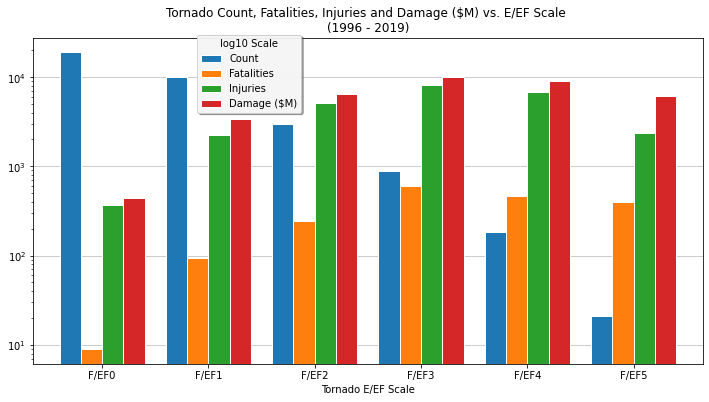

In [57]:
# Generate bar plot
fig, ax = plt.subplots(figsize=(12, 6))
ef012345_df.plot('TOR_F_SCALE', 
                 ['Count', 'Deaths', 'Injuries', 'Damage'], 
                 kind='bar', 
                 logy=True, 
                 alpha=1,
                 rot=0,
                 legend=True,
                 width=0.8,
                 edgecolor='w',
                 ax=ax)                                       

# Set textual properties
plt.title('Tornado Count, Fatalities, Injuries and Damage ($M) vs. E/EF Scale \n(1996 - 2019)')
plt.xlabel('Tornado E/EF Scale')
#plt.ylabel('Tornado Count, Fatalities, Injuries, Damage (log10)')

plt.legend(('Count', 'Fatalities', 'Injuries', 'Damage ($M)'), 
           fancybox=True, shadow=True, framealpha=0.9, loc=(0.245, 0.77), title='log10 Scale')

# set grid for y axis
ax.set_axisbelow(True)
ax.grid(axis='y', alpha=0.8)

#plt.savefig('./Images/Tornado Count & Measurements of Impact vs. E&EF Scale.png')

plt.show()

Our data are spread over a wide range of values so it will be easier to read the chart if we use a logarithmic scale for y-axis. 

It is obvious that smaller number of higher scale tornadoes causes much more fatalities than huge number of lower scale tornadoes. Similar behavior is seen for injuries and damage related to tornadoes.

## Tornadoes by Year and Tornado F/EF Scale

Let's display total number of tornadoes per year stacked with tornado F/EF scale.

In [58]:
# Gruop by year and scale and count number of tornadoes per scale
scale_year = ef012345.groupby(['YEAR', 'TOR_F_SCALE']).TOR_F_SCALE.count().to_frame()
# Rename column
scale_year = scale_year.rename(columns={'TOR_F_SCALE': 'Count'})
# Reset index by moving TOR_F_SCALE to columns
scale_year = scale_year.reset_index(level='TOR_F_SCALE')

print(scale_year.shape)
scale_year.head()

(127, 2)


,TOR_F_SCALE,Count
YEAR,,
1996,F/EF0,794
1996,F/EF1,341
1996,F/EF2,102
1996,F/EF3,26
1996,F/EF4,3


In [59]:
# Use pivot_table to reorganize dataframe 
sy_pivot = scale_year.pivot_table(index='YEAR', columns='TOR_F_SCALE', values='Count')
# Fill NaNs with 0
sy_pivot.fillna(0, inplace=True)

sy_pivot.head()

TOR_F_SCALE,F/EF0,F/EF1,F/EF2,F/EF3,F/EF4,F/EF5
YEAR,,,,,,
1996,794.0,341.0,102.0,26.0,3.0,1.0
1997,756.0,294.0,89.0,31.0,9.0,1.0
1998,914.0,416.0,137.0,48.0,11.0,3.0
1999,888.0,381.0,164.0,69.0,16.0,2.0
2000,763.0,293.0,83.0,27.0,3.0,0.0


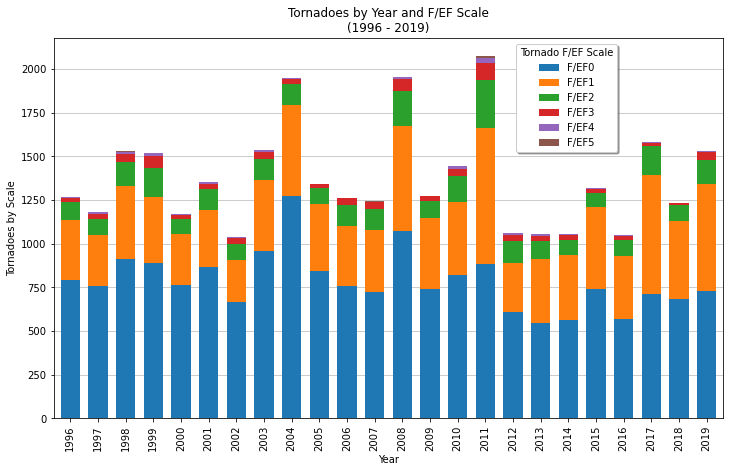

In [60]:
# Generate bar plot
fig, ax = plt.subplots(figsize=(12, 7))
sy_pivot.plot(kind='bar', 
              stacked=True,
              logy=False, 
              alpha=1,
              rot=90,
              legend=True,
              width=0.7,
              ax=ax)                                       

# Set textual properties
plt.title('Tornadoes by Year and F/EF Scale\n(1996 - 2019)')
plt.xlabel('Year')
plt.ylabel('Tornadoes by Scale')

plt.legend(title='Tornado F/EF Scale', fancybox=True, shadow=True, loc=(0.69, 0.7))

# set grid for y axis
ax.set_axisbelow(True)
ax.grid(axis='y', alpha=0.8)

#plt.savefig('./Images/Tornadoes by Year and E-EF Scale.png')

plt.show()

There are two years, 2004 and 2008, with almost 2000 tornadoes. The most tornadoes was recorded in 2011. Majority of tornadoes belong to F/EF0 and F/EF1 scale and then slghtly less in F/EF2.

Let's now use stacked area chart to display F/EF4 and F/EF5 tornades by year.

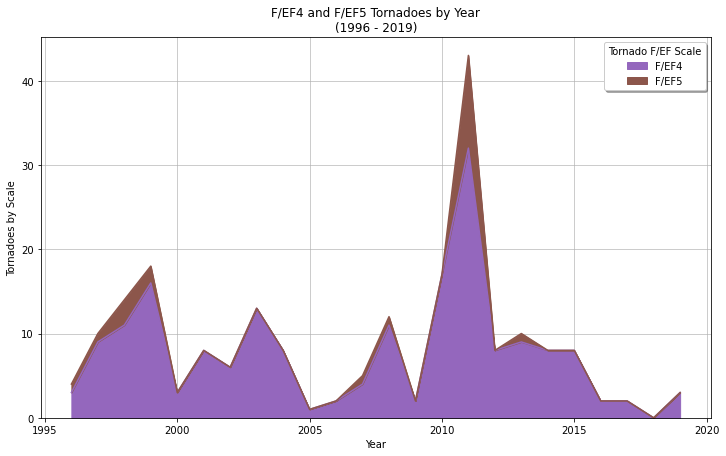

In [61]:
# Generate bar plot
fig, ax = plt.subplots(figsize=(12, 7))
colors = ['#9467bd', '#8c564b']
sy_pivot.iloc[:, 4:6].plot(kind='area', 
                          stacked=True,
                          logy=False,
                          color=colors,
                          alpha=1,
                          rot=0,
                          legend=True,
                          ax=ax)                                       

# Set textual properties
plt.title('F/EF4 and F/EF5 Tornadoes by Year\n(1996 - 2019)')
plt.xlabel('Year')
plt.ylabel('Tornadoes by Scale')

plt.legend(title='Tornado F/EF Scale', fancybox=True, shadow=True)

# set grid for y axis
ax.set_axisbelow(True)
ax.grid(axis='both', alpha=0.8)

#plt.savefig('./Images/F-EF4 and F-EF5 Tornadoes by Year.png')

plt.show()

There is a peak of tornado frequency for both scales in 2011.

# EF and F Scale Analysis

## Storm Rating Frequency

The EF and F Scale are assigned to tornados to establish a "rating". This is based on estimated wind speed and damage associated with the storm. Damage Indicators (DIs) and Degrees of Damage (DoD) are considered to estimate the range of wind speeds the tornado likely produced. 

The EF Scale was revised from the original Fujita Scale (in 2007) to reflect better examinations of tornado damage surveys so as to align wind speeds more closely with associated storm damage. The new scale reflects how most structures are designed.
(from https://www.weather.gov/oun/efscale)


In [62]:
# create df copy
scale_df = df_tor.copy()

# The data set has both the F scale and EF scale. To provide a full summary, the EF and F scale data was combined

scale_df = scale_df.replace("F0", "EF0")
scale_df = scale_df.replace("F1", "EF1")
scale_df = scale_df.replace("F2", "EF2")
scale_df = scale_df.replace("F3", "EF3")
scale_df = scale_df.replace("F4", "EF4")
scale_df = scale_df.replace("F5", "EF5")
scale_df

,EVENT_ID,STATE,YEAR,MONTH_NAME,BEGIN_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,INJURIES,DEATHS,DAMAGE
0,5539021,MISSOURI,1996,January,18-JAN-96 08:05:00,EF1,36.1800,-89.8700,0,0,50000.0
1,5535520,ARKANSAS,1996,January,18-JAN-96 07:30:00,EF1,34.5500,-90.9700,3,0,30000.0
2,5574627,LOUISIANA,1996,January,26-JAN-96 09:35:00,EF1,30.5700,-92.3200,3,0,15000.0
3,5558382,INDIANA,1996,January,18-JAN-96 14:30:00,EF0,40.5000,-86.9700,0,0,0.0
4,5535845,TEXAS,1996,January,17-JAN-96 21:55:00,EF2,33.7200,-96.1500,5,0,150000.0
...,...,...,...,...,...,...,...,...,...,...,...
33001,857256,SOUTH DAKOTA,2019,September,09-SEP-19 14:37:00,EF0,44.8943,-97.2062,0,0,0.0
33002,857252,SOUTH DAKOTA,2019,September,09-SEP-19 14:39:00,EF0,44.7497,-97.2096,0,0,0.0
33003,857253,SOUTH DAKOTA,2019,September,09-SEP-19 17:55:00,EF0,45.3805,-97.5119,0,0,0.0
33004,857255,SOUTH DAKOTA,2019,September,09-SEP-19 19:14:00,EF0,45.4261,-97.6842,0,0,0.0


In [63]:
# Data is grouped by TOR_F_SCALE and then value counts are taken
grouped_df = scale_df.groupby("TOR_F_SCALE")
type_amt = grouped_df["TOR_F_SCALE"].value_counts()
type_amt =pd.DataFrame(type_amt)
type_amt = type_amt.rename(columns={"TOR_F_SCALE": "INDEX", "TOR_F_SCALE": "STORM RATING", "TOR_F_SCALE":"COUNT"})


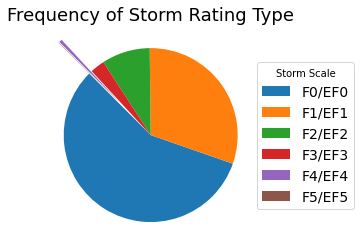

In [64]:
# Once grouped and summed, the frequency of each rating can be shown with the pie chart below

labels=('F0/EF0','F1/EF1', "F2/EF2","F3/EF3", "F4/EF4", "F5/EF5")
explode = (0, 0, 0, 0, .5,.5) 
type_amt.plot(y="COUNT", kind="pie", labels=[" "," "," "," "," "," "], figsize =(6,4), 
              pctdistance=1.25, label = " ", radius=1, explode=explode, fontsize=18, 
              legend=True, startangle=135)
plt.legend(title="Storm Scale", labels=labels,
            bbox_to_anchor=(1,0.5), loc="center right", 
            fontsize=14, bbox_transform=plt.gcf().transFigure)
plt.title("Frequency of Storm Rating Type", fontsize=18)
plt.ylabel(" ")

#plt.savefig('./Images/FrequencyPie.png')
plt.show()

The pie chart and summary table above shows how rare F5/EF5 tornados are during the 23 year span. Next we will explore the combined damage, injuries and deaths caused by each storm rating.

## Damage, Injuries and Death by Storm Rating

In [65]:
# find sum of damages - convert to currency - CPI changes were not taken into account for year to year currency
damages = grouped_df["DAMAGE"].sum()
damages1 = pd.DataFrame(damages)
damages2 = pd.DataFrame(damages)
damages2
damages1['DAMAGE'] = damages1['DAMAGE'].apply(lambda x: "${:,.2f}".format((x/1000)))

In [66]:
# find sum of injuries
injuries = grouped_df["INJURIES"].sum()
injuries = pd.DataFrame(injuries)


In [67]:
# find sum of deaths
deaths = grouped_df["DEATHS"].sum()
deaths = pd.DataFrame(deaths)

In [68]:
# create summary table
scale_summary = pd.concat([damages1, injuries, deaths], axis=1)
scale_summary.reset_index(inplace=True)
scale_summary


,TOR_F_SCALE,DAMAGE,INJURIES,DEATHS
0,EF0,"$436,804.82",373,9
1,EF1,"$3,371,042.10",2252,94
2,EF2,"$6,456,014.40",5132,245
3,EF3,"$10,058,666.75",8055,604
4,EF4,"$9,132,572.00",6770,471
5,EF5,"$6,205,705.00",2361,397


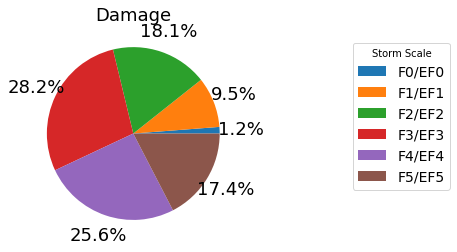

<Figure size 432x288 with 0 Axes>

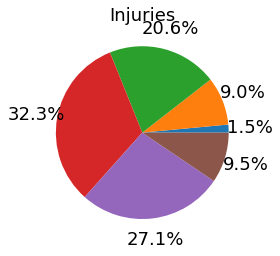

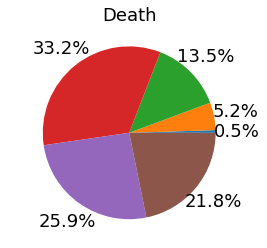

In [69]:
plt.figure(0)
labels=('F0/EF0','F1/EF1', "F2/EF2","F3/EF3", "F4/EF4", "F5/EF5")

damages.plot(y=["DAMAGES"], kind="pie", labels=[" "," "," "," "," "," "], figsize =(6,4),
              pctdistance=1.25, label = " ", radius=1, legend=True, autopct='%1.1f%%',fontsize=18)
plt.legend(title="Storm Scale", labels=labels,
            bbox_to_anchor=(1,0.5), loc="center right", 
            fontsize=14, bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5)
plt.title("Damage", fontsize=18, pad=5)
#plt.savefig('./Images/DamagesChart.png')

plt.figure(1)
injuries.plot(y="INJURIES", kind="pie", labels=[" "," "," "," "," "," "], figsize =(6,4),
              pctdistance=1.25, label = " ", radius=1, legend=None, autopct='%1.1f%%',fontsize=18)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5)
plt.title("Injuries", fontsize=18, pad=1.1)
plt.ylabel(" ")
#plt.savefig('./Images/InjuriesChart.png')

plt.figure(2)
deaths.plot(y="DEATHS", kind="pie", labels=[" "," "," "," "," "," "], figsize =(6,4),
              pctdistance=1.25, label = " ", radius=1, legend=None,autopct='%1.1f%%',fontsize=18)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5)
plt.title("Death", fontsize=18, pad=1.1)
plt.ylabel(" ")

#plt.savefig('./Images/DeathChart.png')
plt.show()

## EF5 and F5 Closer Look

In [70]:
scale_index = df_tor.set_index("TOR_F_SCALE")
top_tor = scale_index.loc[["EF5"]]

In [71]:
year_list = top_tor["YEAR"].tolist()
year_list = top_tor["YEAR"].tolist()

marker_locations = top_tor[['BEGIN_LAT', 'BEGIN_LON']]
year = top_tor["YEAR"]
# Create a marker_layer using the year list to fill the info box 
fig = gmaps.figure()
markers = gmaps.marker_layer(marker_locations, info_box_content=[f"Year: {year}" for year in year_list])

fig.add_layer(markers)

fig

Figure(layout=FigureLayout(height='420px'))

Text(0.5, 1.0, 'EF5/F5 Storms per Year')

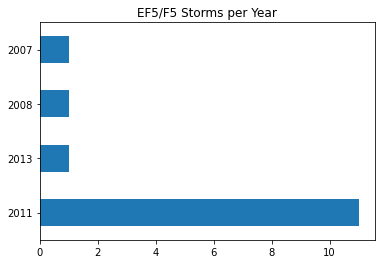

In [72]:
scale_index = df_tor.set_index("TOR_F_SCALE")
top_tor = scale_index.loc[["EF5"]]
year_count = top_tor["YEAR"].value_counts()
year_count = pd.DataFrame(year_count)
year_count.plot(kind="barh", legend=False)
plt.title("EF5/F5 Storms per Year")


Text(0.5, 1.0, 'EF/F5 Storms per State')

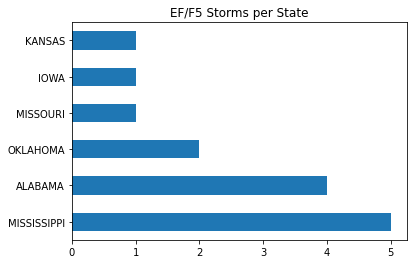

In [73]:
state_count = top_tor["STATE"].value_counts()
state_count = pd.DataFrame(state_count)
state_count.plot(kind="barh", legend=False)
plt.title("EF/F5 Storms per State")

# Damage Stats and FEMA Data

## Damage Stats By Year

This takes the original data in dollars and adds a column for Millions and Billions.

In [74]:
torn1 = df_tor.groupby(['YEAR']).sum()

In [75]:
torn = df_tor.groupby(['YEAR']).count()
torn1['Event Count'] = torn['EVENT_ID']

In [76]:
torn1['Damage_M'] = torn1['DAMAGE']/1000000
torn1['Damage_B'] = torn1['DAMAGE']/1000000000

In [77]:
torn2 = torn1.drop(['EVENT_ID','BEGIN_LAT','BEGIN_LON'], axis=1)
torn2 = torn2.reset_index()

years = torn2['YEAR']
valuesM = torn2['Damage_M']
valuesB = torn2['Damage_B']

## Damage Stats By Year (Real 2019 Dollars)

This takes the nominal dollars in each year and converts the damage amounts into inflation adjusted values represented by 2019 dollars.

In [78]:
damagesM = []
damagesB = []

for x in range(len(years)-1):
    damagesM.append(cpi.inflate(valuesM[x], years[x], to=2019))
    damagesB.append(cpi.inflate(valuesB[x], years[x], to=2019))

damagesM.append(valuesM[23])
damagesB.append(valuesB[23])
torn2['Damage_M2019'] = damagesM
torn2['Damage_B2019'] = damagesB

torn2 = torn2.drop('DAMAGE', axis=1)
torn2.head()

,YEAR,INJURIES,DEATHS,Event Count,Damage_M,Damage_B,Damage_M2019,Damage_B2019
0,1996,705,26,1267,732.10175,0.732102,1192.905909,1.192906
1,1997,1033,68,1180,736.48685,0.736487,1173.134072,1.173134
2,1998,1874,130,1529,1738.10160,1.738102,2726.121722,2.726122
3,1999,1842,94,1520,1998.11245,1.998112,3066.215094,3.066215
4,2000,882,41,1169,430.54310,0.430543,639.206488,0.639206


### Damage Visualization 1

The first visualization of damage estimates shows the number of tornado events in each year (represented by the height of each bubble on the x axis) and the damage in Millions (represent by the size of each bubble) and the number of deaths (represented by the color of each bubble).

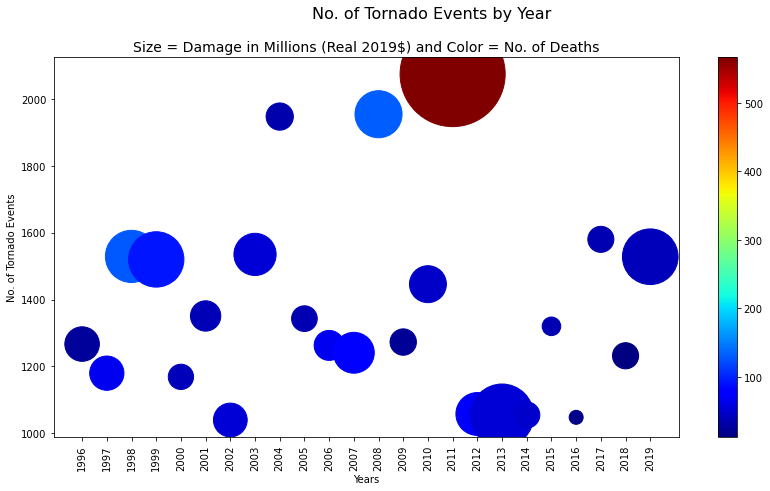

In [79]:
fig = plt.figure(figsize=(14,7)) 
plt.suptitle('No. of Tornado Events by Year', fontsize=16)
ax = fig.add_subplot(111)
cm = plt.cm.get_cmap('jet')
torn2.plot.scatter(x='YEAR', y='Event Count', s=torn2['Damage_M2019'],
                c=torn2['DEATHS'], ax=ax, cmap=cm)
ax.set(xlabel='Years', ylabel='No. of Tornado Events')
ax.set_xticks(years)
ax.set_xticklabels(years,rotation=90)

plt.title('Size = Damage in Millions (Real 2019$) and Color = No. of Deaths', fontsize=14)
plt.show()
#fig.savefig("./Images/Tornado Frequency and Impacts by Year.png")

### Damage Visualization 2

This data visualization shows each of the measurements of impact (Deaths, Injuries, and Damage) for each year and how they are similar.  

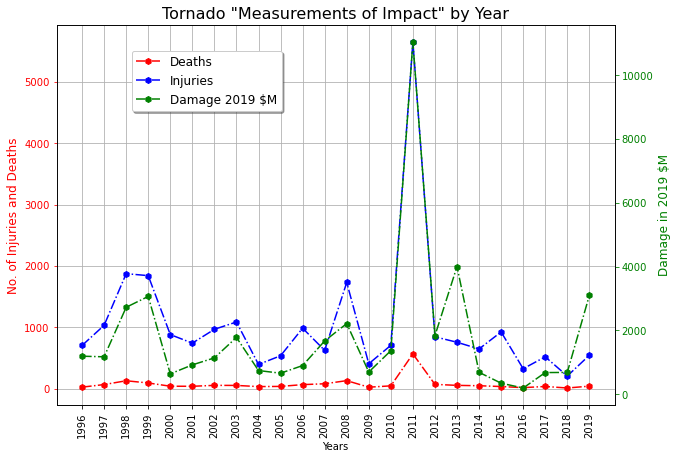

In [80]:
years = torn2['YEAR']

fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot()
ax = torn2['DEATHS'].plot(kind='line', figsize=(10, 7), label='Deaths', color='red', marker='h', linestyle='dashdot')
ax1 = torn2['INJURIES'].plot(kind='line', figsize=(10, 7), label='Injuries', color='blue', marker='h', linestyle='dashdot')

ax2 = ax.twinx()
ax2 = torn2['Damage_M2019'].plot(kind='line', figsize=(10, 7), color='green', 
                                 label='Damage 2019 $M', marker='h', linestyle='dashdot')

ax.grid(which='major', axis='both')
ax.set_title('Tornado "Measurements of Impact" by Year', fontsize=16)

ax.set(xlabel='Years')
ax.set_xticks(range(0,24,1))
ax.set_xticklabels(years,rotation=90)

ax.set_ylabel(ylabel='No. of Injuries and Deaths', color='r', fontsize=12)
ax.tick_params('y', colors='r')
ax2.set_ylabel(ylabel='Damage in 2019 $M', color='g', fontsize=12)
ax2.tick_params('y', colors='g')

fig.legend(loc=5, bbox_to_anchor=(0.4, 0.75), fontsize=12, shadow=True)

plt.show()
#fig.savefig("./Images/Tornado Impacts by Year.png")

## FEMA Data Import

In an effort to find additional data to support the measurement of damage reported by the National Weather Service.  We also explored the Federal Emergency Management Agency (FEMA) and the various datasets they have available to report damage for specific disasters and programs that provide assistance in these types of emergencies.

https://www.fema.gov/data-sets

https://www.fema.gov/openfema-dataset-public-assistance-funded-projects-details-v1

Based off of our findings, we concentrated on the Public Assistance FEMA Program that provides direct assistance to individuals during natural disasters.  The following data represents only Declared Disaster events and the damage estimates for each type and incident.  Therefore, we can look at all FEMA public assistance and then divide it into only "Tornado" FEMA public assistance and compare how that looks against the National Weather Service damage estimates.

In [81]:
# Read the file and create dataframe
df_fema = pd.read_csv('./Resources/PAFundedFEMAProjects.csv')

In [82]:
df_fema1 = df_fema.drop(['declarationDate','applicationTitle','applicantId','dcc','damageCategory',
                         'pwNumber','county','countyCode','stateCode','stateNumberCode','hash','lastRefresh','id'], axis=1)
df_fema2 = df_fema1.rename(columns={'disasterNumber':'Disaster','incidentType':'Type','damageCategoryCode':'Damage Category',
                                    'projectSize':'Project Size','state':'State','projectAmount':'Project Estimate',
                                    'federalShareObligated':'FEMA Share','totalObligated':'Project Actual',
                                    'obligatedDate':'Date'})
df_fema2['Year'] = df_fema2['Date'].str[:4]

In [83]:
fema4 = df_fema2.groupby(['Type']).sum()
fema4['Estimate $M'] = fema4['Project Estimate']/1000000
fema4['FEMA Share $M'] = fema4['FEMA Share']/1000000
fema4['Actual $M'] = fema4['Project Actual']/1000000
fema4 = fema4.drop(['Disaster'], axis=1)
fema4 = fema4.loc[:,['Estimate $M','FEMA Share $M','Actual $M']]
fema4 = fema4.reset_index()
fema4['Actual $B'] = round(fema4['Actual $M']/1000,2)

In [84]:
df_fema3 = df_fema2[df_fema['incidentType'] == "Tornado"]

### Data Visualization 3 - ALL FEMA Public Assistance Data

This data shows the amount of FEMA Public Assistance damage estimates based on types of natural disasters.  We can see that the most common type funded by FEMA during this period from 2000 - 2019 is for Hurricanes, but that other Servere Storm(s) are in second place with almost 14B over those 20 years.  Tornadoes are #11 on the list and they only accounted for 340M in damage public assistance from FEMA.  That is significantly lower than the damage estimates from the National Weather Service.

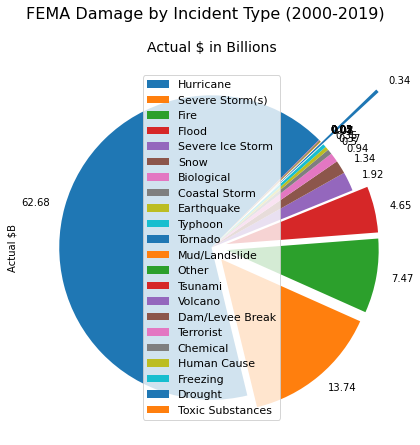

In [85]:
fema4_sorted = fema4.sort_values(['Actual $B'],ascending=False)
index = range(1, len(fema4)+1)
types = fema4_sorted['Type']
explode = [0,.1,.1,.1,0,0,0,0,0,0,.5,0,0,0,0,0,0,0,0,0,0,0]
values = fema4_sorted['Actual $B']

fig = plt.figure(figsize=(7,7)) 
ax = fig.add_subplot(111)
fema4_sorted['Actual $B'].plot(kind='pie', ax=ax, explode=explode, startangle=45, labels=values)
plt.suptitle('FEMA Damage by Incident Type (2000-2019)', fontsize=16)
ax.set_title('Actual $ in Billions', fontsize=14)

ax.legend(types, loc='center', fontsize=11)
#fig.savefig("./Images/FEMA Natural Disasters by Type.png")

## FEMA Data in Real $ for 2019

Again, we take the nominal dollars in each year and convert the damage amounts into inflation adjusted values represented by 2019 dollars.

In [86]:
fema3 = df_fema3.groupby(['Year']).sum()
fema3['Estimate $M'] = fema3['Project Estimate']/1000000
fema3['FEMA Share $M'] = fema3['FEMA Share']/1000000
fema3['Actual $M'] = fema3['Project Actual']/1000000
fema3 = fema3.drop(['Disaster'], axis=1)
fema3 = fema3.loc[:,['Estimate $M','FEMA Share $M','Actual $M']]
fema3 = fema3.drop(['1999','2020'])
fema3 = fema3.reset_index()

In [87]:
years = fema3['Year']
newyears = [int(years[x]) for x in range(len(years))]
valuesM = fema3['Actual $M']

In [88]:
damagesM = []

for x in range(len(years)):
    damagesM.append(cpi.inflate(valuesM[x], newyears[x], to=2019))

fema3['Actual $M 2019'] = damagesM
fema3.head()

,Year,Estimate $M,FEMA Share $M,Actual $M,Actual $M 2019
0,2000,10.860992,8.145022,8.448227,12.542674
1,2001,2.697911,1.818004,1.905184,2.750274
2,2002,20.813817,15.513554,16.197987,23.019059
3,2003,15.861656,11.869809,12.337311,17.141956
4,2004,1.744502,1.308377,1.350654,1.827974


### Data Visualization 4 - FEMA in Real $ 2019

In the first visualization of FEMA damage for only "Tornado" events, we see those damage amounts represented by year in the following line plot.

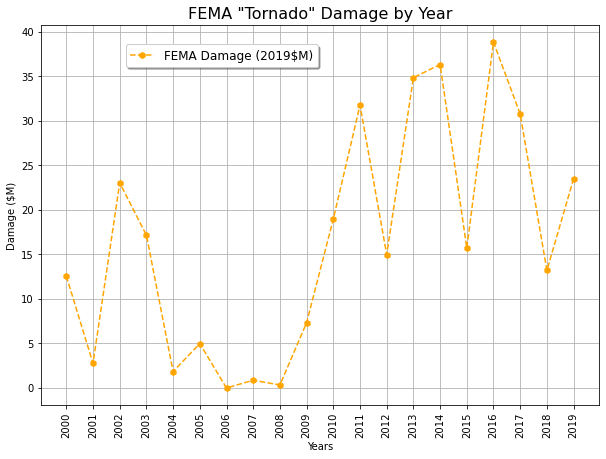

In [89]:
fig = plt.figure(figsize=(10,7)) 
ax = fig.add_subplot(111)

fema3['Actual $M 2019'].plot(kind='line', linestyle='dashed', marker='h', color="orange", ax=ax, label = "FEMA Damage (2019$M)")

ax.set(xlabel='Years', ylabel='Damage ($M)')
ax.set_title('FEMA "Tornado" Damage by Year', fontsize=16)
ax.set_xticks(range(0,20,1))
ax.set_xticklabels(years,rotation=90)

ax.grid(which='major',axis='both')
fig.legend(loc=5, bbox_to_anchor=(0.45, 0.8), fontsize=12, shadow=True)

plt.show()
#fig.savefig("./Images/FEMA Damage in Real 2019 $M.png")

There is no public assistance included in the data set for years prior to 2000.  There is a good possibility that some of the "Severe Storm" incidents were not classified as "Tornado" incidents.  Therefore, we are dropping the data prior to 2000 from the National Weather Service (NWS) data to compare them on the next visualization.

In [90]:
torn3 = torn2.set_index('YEAR')
torn3 = torn3.drop([1996,1997,1998,1999], axis=0)
torn3 = torn3.reset_index()

### Data Visualization 5 - Tornado Damage (FEMA vs NWS)

This shows the FEMA damage estimates and the NWS damage estimates (both in real inflation adjusted 2019 dollars) plotted together on the same visualization.

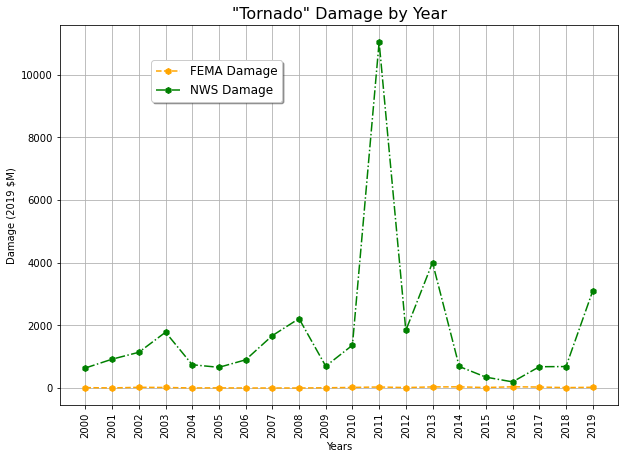

In [91]:
years = fema3['Year']

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

ax = fema3['Actual $M 2019'].plot(kind='line', linestyle='dashed', marker='h', color="orange", ax=ax, label = "FEMA Damage")
ax2 = torn3['Damage_M2019'].plot(kind='line', color='green', label='NWS Damage', marker='h', ax=ax, linestyle='dashdot')

ax.set_title('"Tornado" Damage by Year', fontsize=16)
ax.grid(which='major',axis='both')

ax.set(xlabel='Years', ylabel='Damage (2019 $M)')
ax.set_xticks(range(0,20,1))
ax.set_xticklabels(years,rotation=90)

fig.legend(loc=5, bbox_to_anchor=(0.4, 0.75), fontsize=12, shadow=True)

plt.show()
#fig.savefig("./Images/NWS Tornado Damage vs FEMA Tornado Damage in Real 2019 $M.png")

Our conclusion, the FEMA public assistance program does not typically provide assistance for disasters that are related to tornado events.  In fact, in doing additional research, typically private property insurance claims will cover most of the property damage and related damages associated with tornadoes (ie. winds, debris, and medical), while FEMA is more focused on providing tornado assistance in other ways -- through other FEMA programs related to all tornadoes, such as Prediction, Preparedness and Education efforts to help increase public awareness and decrease the potential impact of all events.

## FEMA Data for ALL Events

Based on that conclusion, we included the FEMA public assistance damage from ALL events to the previous representation and you can see that it often doesn't even match up to the worst years in terms of tornado activity and impact at all. 

In [92]:
fema5 = df_fema2.groupby(['Year']).sum()
fema5['Estimate $M'] = fema5['Project Estimate']/1000000
fema5['FEMA Share $M'] = fema5['FEMA Share']/1000000
fema5['Actual $M'] = fema5['Project Actual']/1000000
fema5 = fema5.drop(['Disaster'], axis=1)
fema5 = fema5.loc[:,['Estimate $M','FEMA Share $M','Actual $M']]
fema5 = fema5.drop(['1991','1992','1993','1994','1995','1996','1997','1998','1999','2020'])
fema5 = fema5.reset_index()

In [93]:
years = fema5['Year']
newyears = [int(years[x]) for x in range(len(years))]
valuesM = fema5['Actual $M']
damagesM = []

for x in range(len(years)):
    damagesM.append(cpi.inflate(valuesM[x], newyears[x], to=2019))

fema5['Actual $M 2019'] = damagesM

### Data Visualization 6 - NWS Tornado Damage vs FEMA All Events

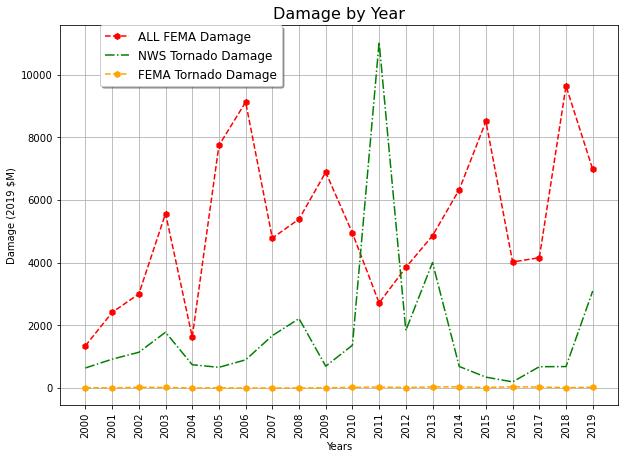

In [94]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

ax = fema5['Actual $M 2019'].plot(kind='line', linestyle='dashed', marker='h', color="red", ax=ax, label = "ALL FEMA Damage")
ax2 = torn3['Damage_M2019'].plot(kind='line', color='green', label='NWS Tornado Damage', ax=ax, linestyle='dashdot')
ax3 = fema3['Actual $M 2019'].plot(kind='line', linestyle='dashed', marker='h', color="orange", ax=ax, label = "FEMA Tornado Damage")

ax.set_title('Damage by Year', fontsize=16)
ax.grid(which='major',axis='both')

ax.set(xlabel='Years', ylabel='Damage (2019 $M)')
ax.set_xticks(range(0,20,1))
ax.set_xticklabels(years,rotation=90)

fig.legend(loc=5, bbox_to_anchor=(0.4, 0.8), fontsize=12, shadow=True)

plt.show()
#fig.savefig("./Images/NWS Tornado Damage vs FEMA All Events Damage in Real 2019 $M.png")